In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.models import Word2Vec, KeyedVectors
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_excel("Womens Clothing Reviews Data.xlsx")

In [ ]:
data = data.drop(columns = ['Product ID','Category','Subcategory1','SubCategory2','Location','Channel','Customer Age','Review Title', 'Recommend Flag', 'Rating'])

In [ ]:
data = data.dropna()

In [ ]:
#Sentiment Analysis by using SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer()
polarity = [sent.polarity_scores(i)['compound'] for i in data['Review Text']]
data['sentiment_score'] = polarity

In [ ]:
data['sentiment'] = data['sentiment_score'].apply(lambda x:1 if x>0.5 else 0)

In [ ]:
data = data.drop(columns = ['sentiment_score'])

In [ ]:
data

,Review Text,sentiment
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,1
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1
...,...,...
23481,I was very happy to snag this dress at such a ...,1
23482,"It reminds me of maternity clothes. soft, stre...",1
23483,"This fit well, but the top was very see throug...",1
23484,I bought this dress for a wedding i have this ...,1


In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ysnit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ysnit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Importing pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn.utils.rnn import pad_sequence
import string

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = re.sub(r'[^\w\s]', '', str(text).lower())
    tokens = word_tokenize(text)
    return [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]

data['processed'] = data['Review Text'].apply(preprocess)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# === 3. Train Word2Vec and Convert to Sequences ===
def train_word2vec(corpus, vector_size=100):
    return Word2Vec(sentences=corpus, vector_size=vector_size, window=5, min_count=2, workers=4)

w2v_model = train_word2vec(data['processed'].tolist())
pretrained_embeddings = w2v_model.wv.vectors
embedding_dim = pretrained_embeddings.shape[1]
vocab_size = pretrained_embeddings.shape[0]
word2idx = w2v_model.wv.key_to_index


In [ ]:
# Padding Sequences
def texts_to_sequences(texts, word2idx):
    return [[word2idx[word] for word in text if word in word2idx] for text in texts]

sequences = texts_to_sequences(data['processed'], word2idx)
sequences_padded = pad_sequence([torch.tensor(seq) for seq in sequences], batch_first=True, padding_value=0).to(device)
labels = torch.tensor(data['sentiment'], dtype=torch.long).to(device)

In [ ]:
# === 4. Dataset and Dataloaders ===
dataset = TensorDataset(sequences_padded, labels)
train_len = int(0.8 * len(dataset))
test_len = len(dataset) - train_len
train_ds, test_ds = random_split(dataset, [train_len, test_len])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

In [ ]:
# === 5. GRU Model Definition ===
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size=128, num_layers=2, pretrained_embeddings=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.tensor(pretrained_embeddings))
            self.embedding.weight.requires_grad = True

        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.3)

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )

        self.fc = nn.Linear(hidden_size * 2, 2)  # Binary classification
        self.dropout = nn.Dropout(0.5)
        self.norm = nn.LayerNorm(hidden_size * 2)

    def forward(self, x):
        x = x.long()
        x = self.embedding(x)

        # Create initial hidden state
        h0 = torch.zeros(self.gru.num_layers * 2, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)

        # Apply attention mechanism instead of just taking the last hidden state
        attention_weights = self.attention(out)
        context_vector = torch.sum(attention_weights * out, dim=1)

        # Apply normalization and dropout
        context_vector = self.norm(self.dropout(context_vector))

        # Final classification layer
        logits = self.fc(context_vector)
        return logits

In [ ]:
# Hyperparameters for model
def initialize_model(vocab_size, embedding_dim, pretrained_embeddings):
    # Consistent hyperparameters
    hidden_size = 128
    num_layers = 2  # Make sure this matches what's used in the model constructor

    model = GRUModel(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_size=hidden_size,
        num_layers=num_layers,
        pretrained_embeddings=pretrained_embeddings
    ).to(device)

    return model


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [ ]:
# === 6. Train the Model ===
# === 3. IMPROVED TRAINING FUNCTION ===
def train_model(model, train_loader, test_loader, epochs=20, lr=0.0005):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)  # Changed to AdamW with better weight decay

    # More effective learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )

    # Better early stopping with more patience
    patience = 5  # Increased from 3
    wait = 0  # Initialize the wait variable
    best_val_loss = float('inf')
    best_model_state = None

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()
            _, pred = out.max(1)
            train_correct += (pred == y).sum().item()
            train_total += y.size(0)

        model.eval()
        test_loss, test_correct, test_total = 0, 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                test_loss += loss.item()
                _, pred = out.max(1)
                test_correct += (pred == y).sum().item()
                test_total += y.size(0)

        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        train_acc = 100 * train_correct / train_total
        test_acc = 100 * test_correct / test_total

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        # Update scheduler
        scheduler.step(avg_test_loss)

        print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping logic with model saving
        improved = avg_test_loss < best_val_loss
        if improved:
            best_val_loss = avg_test_loss
            best_model_state = model.state_dict().copy()
            wait = 0
            print(f"✓ New best model saved (loss: {best_val_loss:.4f})")
        else:
            wait += 1
            print(f"◌ No improvement for {wait}/{patience} epochs")

        if wait >= patience:
            print(f"\n Early stopping at epoch {epoch+1}. No improvement for {patience} epochs.")
            break


In [ ]:
# === 7. Initialize and Train ===
model = GRUModel(vocab_size, embedding_dim, pretrained_embeddings=pretrained_embeddings).to(device)
train_model(model, train_loader, test_loader, epochs=20, lr=0.0005)


Epoch 001 | Train Loss: 0.3281 | Test Loss: 0.2996 | Train Acc: 86.29% | Test Acc: 88.08% | LR: 0.000500
✓ New best model saved (loss: 0.2996)
Epoch 002 | Train Loss: 0.2733 | Test Loss: 0.2886 | Train Acc: 88.43% | Test Acc: 89.20% | LR: 0.000500
✓ New best model saved (loss: 0.2886)
Epoch 003 | Train Loss: 0.2314 | Test Loss: 0.2993 | Train Acc: 90.64% | Test Acc: 87.26% | LR: 0.000500
◌ No improvement for 1/5 epochs
Epoch 004 | Train Loss: 0.1924 | Test Loss: 0.3228 | Train Acc: 92.31% | Test Acc: 89.87% | LR: 0.000500
◌ No improvement for 2/5 epochs
Epoch 005 | Train Loss: 0.1505 | Test Loss: 0.3715 | Train Acc: 94.21% | Test Acc: 88.81% | LR: 0.000250
◌ No improvement for 3/5 epochs
Epoch 006 | Train Loss: 0.1055 | Test Loss: 0.4551 | Train Acc: 96.15% | Test Acc: 89.58% | LR: 0.000250
◌ No improvement for 4/5 epochs
Epoch 007 | Train Loss: 0.0854 | Test Loss: 0.5357 | Train Acc: 97.04% | Test Acc: 89.11% | LR: 0.000250
◌ No improvement for 5/5 epochs

⚠️ Early stopping at epoch 7

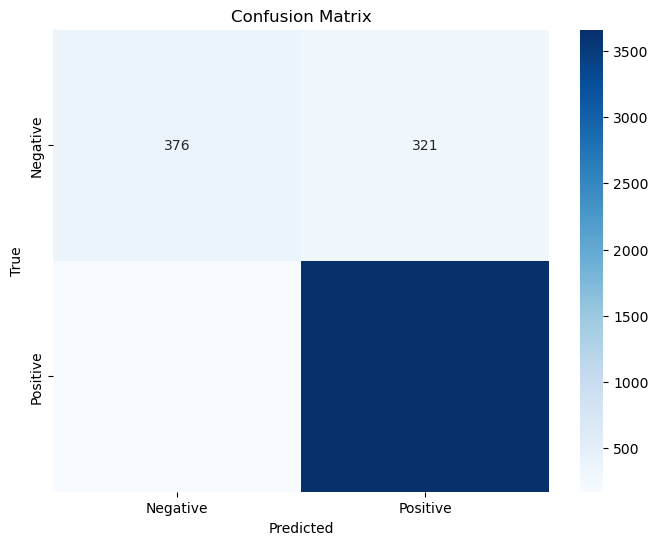

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        _, preds = torch.max(outputs, 1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Now the confusion matrix code will work
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# === 7. INFERENCE FUNCTION ===
# Add this function to make predictions on new text
def predict_sentiment(model, text, word2idx, preprocess_fn):
    model.eval()

    # Preprocess the text
    tokens = preprocess_fn(text)

    # Convert to sequence
    sequence = [word2idx[word] for word in tokens if word in word2idx]

    # Handle empty sequence
    if not sequence:
        return "Unable to predict (no recognized words)"

    # Create tensor and add batch dimension
    tensor = torch.tensor([sequence]).to(device)

    # Get prediction
    with torch.no_grad():
        output = model(tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        prediction = torch.argmax(output, dim=1).item()

    sentiment = "Positive" if prediction == 1 else "Negative"
    confidence = probabilities[0][prediction].item() * 100

    return f"Sentiment: {sentiment} (Confidence: {confidence:.2f}%)"

In [ ]:
import pickle

def save_model_as_pickle(model, word2idx, filename='gru_sentiment_model.pkl'):
    # Create a dictionary of everything you want to save
    model_data = {
        'model_state_dict': model.state_dict(),
        'word2idx': word2idx,
        'model_config': {
            'vocab_size': len(word2idx),
            'embedding_dim': model.embedding.embedding_dim,
            'hidden_size': model.gru.hidden_size,
            'num_layers': model.gru.num_layers,
        }
    }

    # Save to pickle file
    with open(filename, 'wb') as f:
        pickle.dump(model_data, f)

    print(f"Model saved as pickle to {filename}")

# Usage
save_model_as_pickle(model, word2idx)

Model saved as pickle to gru_sentiment_model.pkl


: 

### Training on GRU
